# An Introduction to Football Player Dashboards Using Python and Matplotlib

From the blog [post](https://medium.com/geekculture/an-introduction-to-football-player-dashboards-using-python-and-matplotlib-eb5328dfe85f) at Medium

Link to original jupyter notebook: [GitHub](https://github.com/shreyas7kha/DataVizTutorial/blob/main/DataVizProj.ipynb)

In [35]:
# Imports
import requests
from bs4 import BeautifulSoup as soup
from bs4 import Comment
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplsoccer
from mplsoccer.pitch import VerticalPitch
from highlight_text import ax_text,fig_text

### Scraping from Understat

In [4]:
# Jack Grealish's PLAYER ID IN UNDERSTAT IS 675
url = 'https://understat.com/player/675'
html = requests.get(url)
parse_soup = soup(html.content, 'lxml')

In [5]:
scripts = parse_soup.find_all('script')
shots_data_script = scripts[3].string

ind_start = shots_data_script.index("('")+2
ind_end = shots_data_script.index("')")

shots_data_json = shots_data_script[ind_start:ind_end]
shots_data_json = shots_data_json.encode('utf8').decode('unicode_escape')

In [6]:
data = json.loads(shots_data_json)

In [7]:
x = []
y = []
xg = []
result = []
season = []

In [8]:
for i in range(len(data)):
    for key in data[i]:
        if key=='X':
            x.append(data[i][key])
        if key=='Y':
            y.append(data[i][key])
        if key=='xG':
            xg.append(data[i][key])
        if key=='result':
            result.append(data[i][key])
        if key=='season':
            season.append(data[i][key])

columns = ['X','Y','xG','Result','Season']
df_understat = pd.DataFrame([x, y, xg, result, season], index=columns)
df_understat = df_understat.T
df_understat = df_understat.apply(pd.to_numeric,errors='ignore')

In [9]:
df_understat

,X,Y,xG,Result,Season
0,0.848,0.641,0.056389,SavedShot,2014
1,0.848,0.482,0.103194,BlockedShot,2014
2,0.848,0.718,0.031848,MissedShots,2014
3,0.878,0.579,0.063040,SavedShot,2014
4,0.809,0.702,0.025430,BlockedShot,2014
...,...,...,...,...,...
147,0.895,0.668,0.083522,SavedShot,2020
148,0.847,0.581,0.076474,MissedShots,2020
149,0.765,0.515,0.028961,MissedShots,2020
150,0.781,0.717,0.017552,SavedShot,2020


In [10]:
df_understat['X'] = df_understat['X'].apply(lambda x:x*100)
df_understat['Y'] = df_understat['Y'].apply(lambda x:x*100)

In [11]:
df_understat

,X,Y,xG,Result,Season
0,84.800003,64.099998,0.056389,SavedShot,2014
1,84.800003,48.200001,0.103194,BlockedShot,2014
2,84.800003,71.800003,0.031848,MissedShots,2014
3,87.800003,57.900002,0.063040,SavedShot,2014
4,80.900002,70.199997,0.025430,BlockedShot,2014
...,...,...,...,...,...
147,89.500000,66.800003,0.083522,SavedShot,2020
148,84.699997,58.099998,0.076474,MissedShots,2020
149,76.500000,51.500000,0.028961,MissedShots,2020
150,78.099998,71.699997,0.017552,SavedShot,2020


### Scraping from Fbref

In [12]:
def readfromfbrefhtmlforRPL(url):
    fbref_html = requests.get(url)
    fbref_soup = soup(fbref_html.content, 'lxml')
    comments = fbref_soup.find_all(text=lambda text:isinstance(text, Comment))
    # Таблица со статистикой ударов изначально закомментирована по какой-то причине
    fbref_df = pd.read_html(comments[23])[0]
    
    column_lst = list(fbref_df.columns)
    for index in range(len(column_lst)):
        column_lst[index] = column_lst[index][1]
    
    fbref_df.columns = column_lst
    fbref_df.drop(fbref_df[fbref_df['Player'] == 'Player'].index, inplace=True)
    fbref_df = fbref_df.fillna('0')
    fbref_df.set_index('Rk', drop=True, inplace=True)
    try:
        fbref_df['Nation'] = fbref_df['Nation'].astype(str)
        fbref_df['Nation'] = fbref_df['Nation'].apply(lambda x: x.split()[-1])
    except:
        print('Error in parsing table in url:' + url)
    finally:
        fbref_df = fbref_df.apply(pd.to_numeric, errors='ignore')
    return fbref_df

In [13]:
df_fbref_rus = readfromfbrefhtmlforRPL('https://fbref.com/en/comps/30/shooting/Russian-Premier-League-Stats')
df_fbref_rus

,Player,Nation,Pos,Squad,Age,Born,90s,Gls,Sh,SoT,SoT%,Sh/90,SoT/90,G/Sh,G/SoT,Dist,PK,PKatt,Matches
Rk,,,,,,,,,,,,,,,,,,,
1,Oliver Abildgaard,DEN,MF,Rubin Kazan,25-062,1996,2.0,0,4,1,25.0,2.00,0.50,0.00,0.0,0,0,0,Matches
2,Arsen Adamov,RUS,DF,Ural,21-295,1999,3.0,0,0,0,0.0,0.00,0.00,0.00,0.0,0,0,0,Matches
3,Gamid Agalarov,RUS,FW,Ufa,21-026,2000,1.4,2,3,2,66.7,2.14,1.43,0.67,1.0,0,0,0,Matches
4,Mikhail Ageev,RUS,FW,Ural,21-111,2000,1.2,0,5,1,20.0,4.33,0.87,0.00,0.0,0,0,0,Matches
5,Ilzat Akhmetov,RUS,"MF,FW",CSKA Moscow,23-223,1997,2.4,0,5,0,0.0,2.12,0.00,0.00,0.0,0,0,0,Matches
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,Yuri Zhuravlyov,RUS,DF,Ufa,25-043,1996,3.0,0,3,1,33.3,1.00,0.33,0.00,0.0,0,0,0,Matches
301,Anton Zinkovskiy,RUS,MF,Samara,25-119,1996,2.8,0,9,0,0.0,3.18,0.00,0.00,0.0,0,0,0,Matches
302,Roman Zobnin,RUS,MF,Spartak Moscow,27-181,1994,2.2,0,4,2,50.0,1.81,0.90,0.00,0.0,0,0,0,Matches


In [14]:
def readfromhtml(filepath):
    df = pd.read_html(filepath)[0]
    column_lst = list(df.columns)
    for index in range(len(column_lst)):
        column_lst[index] = column_lst[index][1]
    df.columns = column_lst
    df.drop(df[df['Player'] == 'Player'].index, inplace=True)
    df = df.fillna('0')
    df.set_index('Rk', drop=True, inplace=True)
    try:
        df['Comp'] = df['Comp'].apply(lambda x: ' '.join(x.split()[1:]))
        df['Nation'] = df['Nation'].astype(str)
        df['Nation'] = df['Nation'].apply(lambda x: x.split()[-1])
    except:
        print('Error in uploading file:' + filepath)
    finally:
        df = df.apply(pd.to_numeric, errors='ignore')
    return df

In [15]:
df_fbref_20_21 = readfromhtml('https://fbref.com/en/comps/Big5/2020-2021/shooting/players/2020-2021-Big-5-European-Leagues-Stats')
df_fbref_19_20 = readfromhtml('https://fbref.com/en/comps/Big5/2019-2020/shooting/players/2019-2020-Big-5-European-Leagues-Stats')

### Drawing plots

In [16]:
background = '#D6DBD9'
text_color = 'black'

#### Step 1. Drawing background

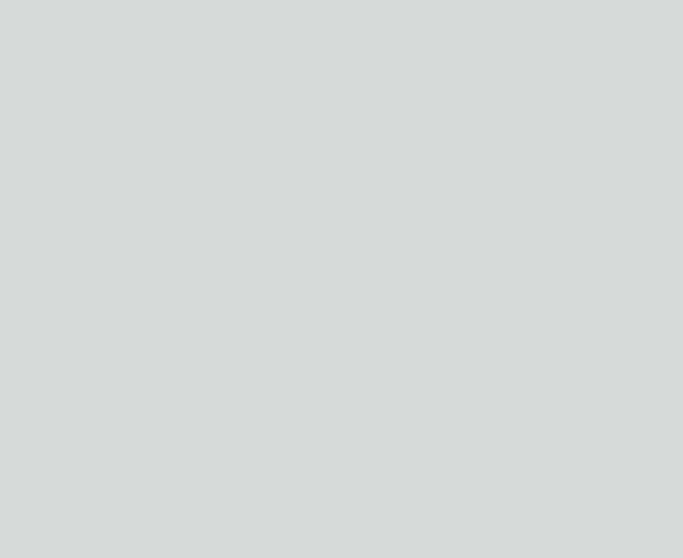

In [34]:
# SETTING UP THE AXES
fig, ax = plt.subplots(figsize=(12,10))
ax.axis('off')
fig.set_facecolor(background)

#### Step 2. Drawing Opta pitch for first season

In [41]:
# SETTING UP THE MPL AXIS FOR THE FIRST SEASON
# The Opta pitch from mplsoccer
pitch = VerticalPitch(half=True, pitch_type='opta', pitch_color='grass')
ax_opta1 = fig.add_axes((0.1, 0.06, 0.4, 0.4))
ax_opta1.patch.set_facecolor(background)
pitch.draw(ax=ax_opta1)

#### Step 3. Plot the goals

In [42]:
# NOW PLOTTING THE GOALS IN THE 2019-20 SEASON
df_fil = df_understat.loc[df_understat['Season']==2019]
pitch.scatter(df_fil[df_fil['Result']=='Goal']['X'],df_fil[df_fil['Result']=='Goal']['Y'], 
              s=np.sqrt(df_fil[df_fil['Result']=='Goal']['xG'])*100, marker='o', alpha=0.9,
              edgecolor='black', facecolor='#6778d0', ax=ax_opta1, label='Goal')